In [1]:
!pip install -qq pymorphy2 pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 72.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
!wget -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=16hd28VqzufDp8gpmIAC4UFAKAPbIrD4R" -O negative.csv
!wget -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1NeluUImkZjwYTVZzK0RehtbWf3BKPike" -O positive.csv

In [5]:
import warnings
warnings.filterwarnings("ignore")

import re
import string
from tqdm import tqdm
from functools import partial

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

import nltk
from nltk.tokenize import word_tokenize, WordPunctTokenizer
from nltk.corpus import stopwords

from pymorphy2 import MorphAnalyzer
import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pd.set_option("display.max_colwidth", None)
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
pymorphy2_analyzer = MorphAnalyzer()
wp_tokenize = WordPunctTokenizer()
punctuation = string.punctuation

russian = stopwords.words("russian")
english = stopwords.words("english")

russian.remove("не")

In [7]:
positive = pd.read_csv("positive.csv", sep=";", usecols=[3], header=None).rename(columns={3: "text"})
negative = pd.read_csv("negative.csv", sep=";", usecols=[3], header=None).rename(columns={3: "text"})
positive["label"] = 0
negative["label"] = 1
df = pd.concat([positive, negative], axis=0).sample(frac=1)

df.head()

,text,label
68890,RT @azamataka: Наблюдать подкаблучников так печально(,1
467,"@stepancheva @nastyakrysyuk_ а я говно, мне цветы не дарят:(",1
7828,"Хочу сказать, что очень люблю этого человечка @alka961 спасибо тебе за все;))",0
93950,"Геля сказала, что меня неудобно обнимать, потому что я слишком худая. \n:(",1
15896,"@helgas_gun блин, как с тобой трудно......... )))))саня. ты ОДИН говоришь ,что со мной трудно.за",0


In [8]:
cache = {}

def preprocess(text: str, 
               remove_punct: bool = True,
               lemma: bool = True,
               min_length: int = 1) -> list:

    if not isinstance(text, str):
        text = str(text)

    text = re.sub("@[\w]*", ' ', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub("\s\s+", " ", text)

    if remove_punct:
        text = re.sub(r"[^a-zA-Zа-яА-Я0-9]", " ", text)
        text = re.sub(r"[^a-zA-Zа-яА-Я]", " ", text)
        text = re.sub(r"[^\w\s]", " ", text)
    else:
        text = re.sub(f"[^a-zA-Zа-яА-Я{punctuation}]", " ", text)

    text = text.lower().strip().replace(',', '')
    text = re.sub(r"(rt|gt|ff|dd)+", " ", text)
    text = [w for w in text.split() if len(w) > min_length]
    text = ' '.join([w for w in text if w not in russian and w not in english])
    
    text = wp_tokenize.tokenize(text)
    if lemma:
        lemm_text = []
        for word in text:
            if word in cache:
                lemm_text.append(cache[word])
            else:
                temp_w = cache[word] = pymorphy2_analyzer.parse(word)[0].normal_form
                lemm_text.append(temp_w)
        return lemm_text
    
    return text

In [97]:
df["text_prep"] = df["text"].apply(preprocess)

In [98]:
dictionary = corpora.Dictionary(df["text_prep"])
dictionary.filter_extremes(no_below=10, no_above=0.8, keep_n=None)

corpus = [dictionary.doc2bow(text) for text in df["text_prep"]]

In [99]:
lda = gensim.models.ldamodel.LdaModel(corpus, 
                                      id2word=dictionary, 
                                      num_topics=3, 
                                      chunksize=50, 
                                      update_every=1, 
                                      passes=4, 
                                      per_word_topics=True, 
                                      alpha='auto', 
                                      random_state=42)

In [100]:
lda.show_topics(num_topics=3, num_words=10, formatted=True)

[(0,
  '0.023*"хотеть" + 0.018*"сегодня" + 0.018*"очень" + 0.016*"быть" + 0.014*"весь" + 0.013*"мой" + 0.013*"любить" + 0.011*"вс" + 0.011*"человек" + 0.011*"делать"'),
 (1,
  '0.140*"не" + 0.021*"день" + 0.017*"такой" + 0.014*"год" + 0.013*"мочь" + 0.011*"завтра" + 0.009*"новый" + 0.009*"вообще" + 0.009*"сказать" + 0.009*"один"'),
 (2,
  '0.051*"это" + 0.018*"ты" + 0.016*"знать" + 0.016*"просто" + 0.011*"думать" + 0.010*"дом" + 0.009*"утро" + 0.008*"время" + 0.008*"школа" + 0.008*"первый"')]

In [101]:
# It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.

print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  0.00034994709926358203


In [102]:
# Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

coherence_model_lda = gensim.models.CoherenceModel(model=lda, texts=df["text_prep"], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.12090871874490476



100%|██████████| 5/5 [17:53<00:00, 214.67s/it]


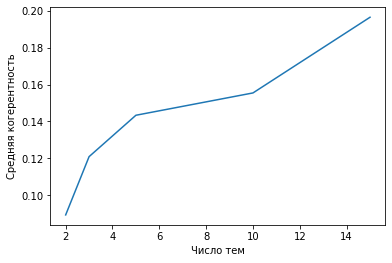

In [125]:
topics_list = [2, 3, 5, 10, 15]
coherences = []

for num in tqdm(topics_list):
    lda_ = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=dictionary, 
                                           num_topics=num, 
                                           chunksize=50, 
                                           update_every=1, 
                                           passes=4, 
                                           per_word_topics=True, 
                                           alpha='auto', 
                                           random_state=42)
    coherences.append(gensim.models.CoherenceModel(model=lda_, texts=df["text_prep"], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()  # more topics -> higher coherence?

In [116]:
# lets try without cleaning, like in classification task
wp_tokenizer = WordPunctTokenizer()
df["full_text"] = df["text"].apply(lambda x: wp_tokenizer.tokenize(x))  # word_tokenizer

In [117]:
full_dictionary = corpora.Dictionary(df["full_text"])
full_dictionary.filter_extremes(no_below=10, no_above=0.9, keep_n=None)

full_corpus = [full_dictionary.doc2bow(text) for text in df["full_text"]]


100%|██████████| 5/5 [28:20<00:00, 340.12s/it]


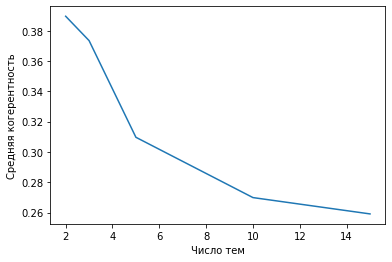

In [124]:
topics_list = [2, 3, 5, 10, 15]
coherences = []

for num in tqdm(topics_list):
    lda_ = gensim.models.ldamodel.LdaModel(full_corpus,
                                           id2word=full_dictionary, 
                                           num_topics=num, 
                                           chunksize=50, 
                                           update_every=1, 
                                           passes=4, 
                                           per_word_topics=True, 
                                           alpha='auto', 
                                           random_state=42)
    coherences.append(gensim.models.CoherenceModel(model=lda_, texts=df["full_text"], dictionary=full_dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [128]:
flda = gensim.models.ldamodel.LdaModel(full_corpus, 
                                       id2word=full_dictionary, 
                                       num_topics=2, 
                                       chunksize=50, 
                                       update_every=1, 
                                       passes=2, 
                                       per_word_topics=True, 
                                       alpha='auto', 
                                       random_state=42)

In [129]:
print('Персплексия: ', np.exp(flda.log_perplexity(full_corpus)))

coherence_lda = gensim.models.CoherenceModel(model=flda, texts=df["full_text"], dictionary=full_dictionary, coherence='c_v').get_coherence()
print('Средняя когерентность: ', coherence_lda) 

Персплексия:  0.0010625386131360903
Средняя когерентность:  0.3895508618999236


In [131]:
flda.show_topics(num_topics=2, num_words=15, formatted=True)  # looks like we got two clusters: happy and sad themes :) But topic descriptions are meaningless

[(0,
  '0.070*"," + 0.038*"@" + 0.025*"не" + 0.021*"и" + 0.020*"в" + 0.020*"я" + 0.019*"." + 0.014*"на" + 0.014*"-" + 0.014*")" + 0.013*"что" + 0.011*":(" + 0.011*"(" + 0.010*"а" + 0.009*"с"'),
 (1,
  '0.098*":" + 0.070*"@" + 0.065*"." + 0.054*"RT" + 0.049*"/" + 0.045*"t" + 0.045*"://" + 0.045*"co" + 0.045*"http" + 0.029*"#" + 0.024*"D" + 0.023*""" + 0.008*":)" + 0.008*"!" + 0.007*"—"')]

In [104]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

In [ ]:
# 1 - feelings and actions
# 2 - negative feelings
# 3 - time + feelings + memories

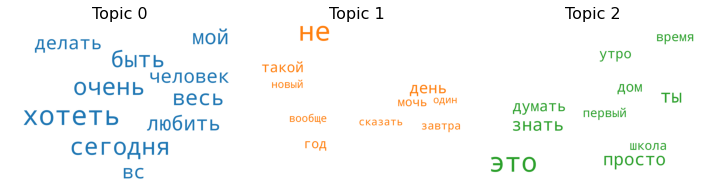

In [105]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#13.-t-SNE-Clustering-Chart

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=russian+english,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

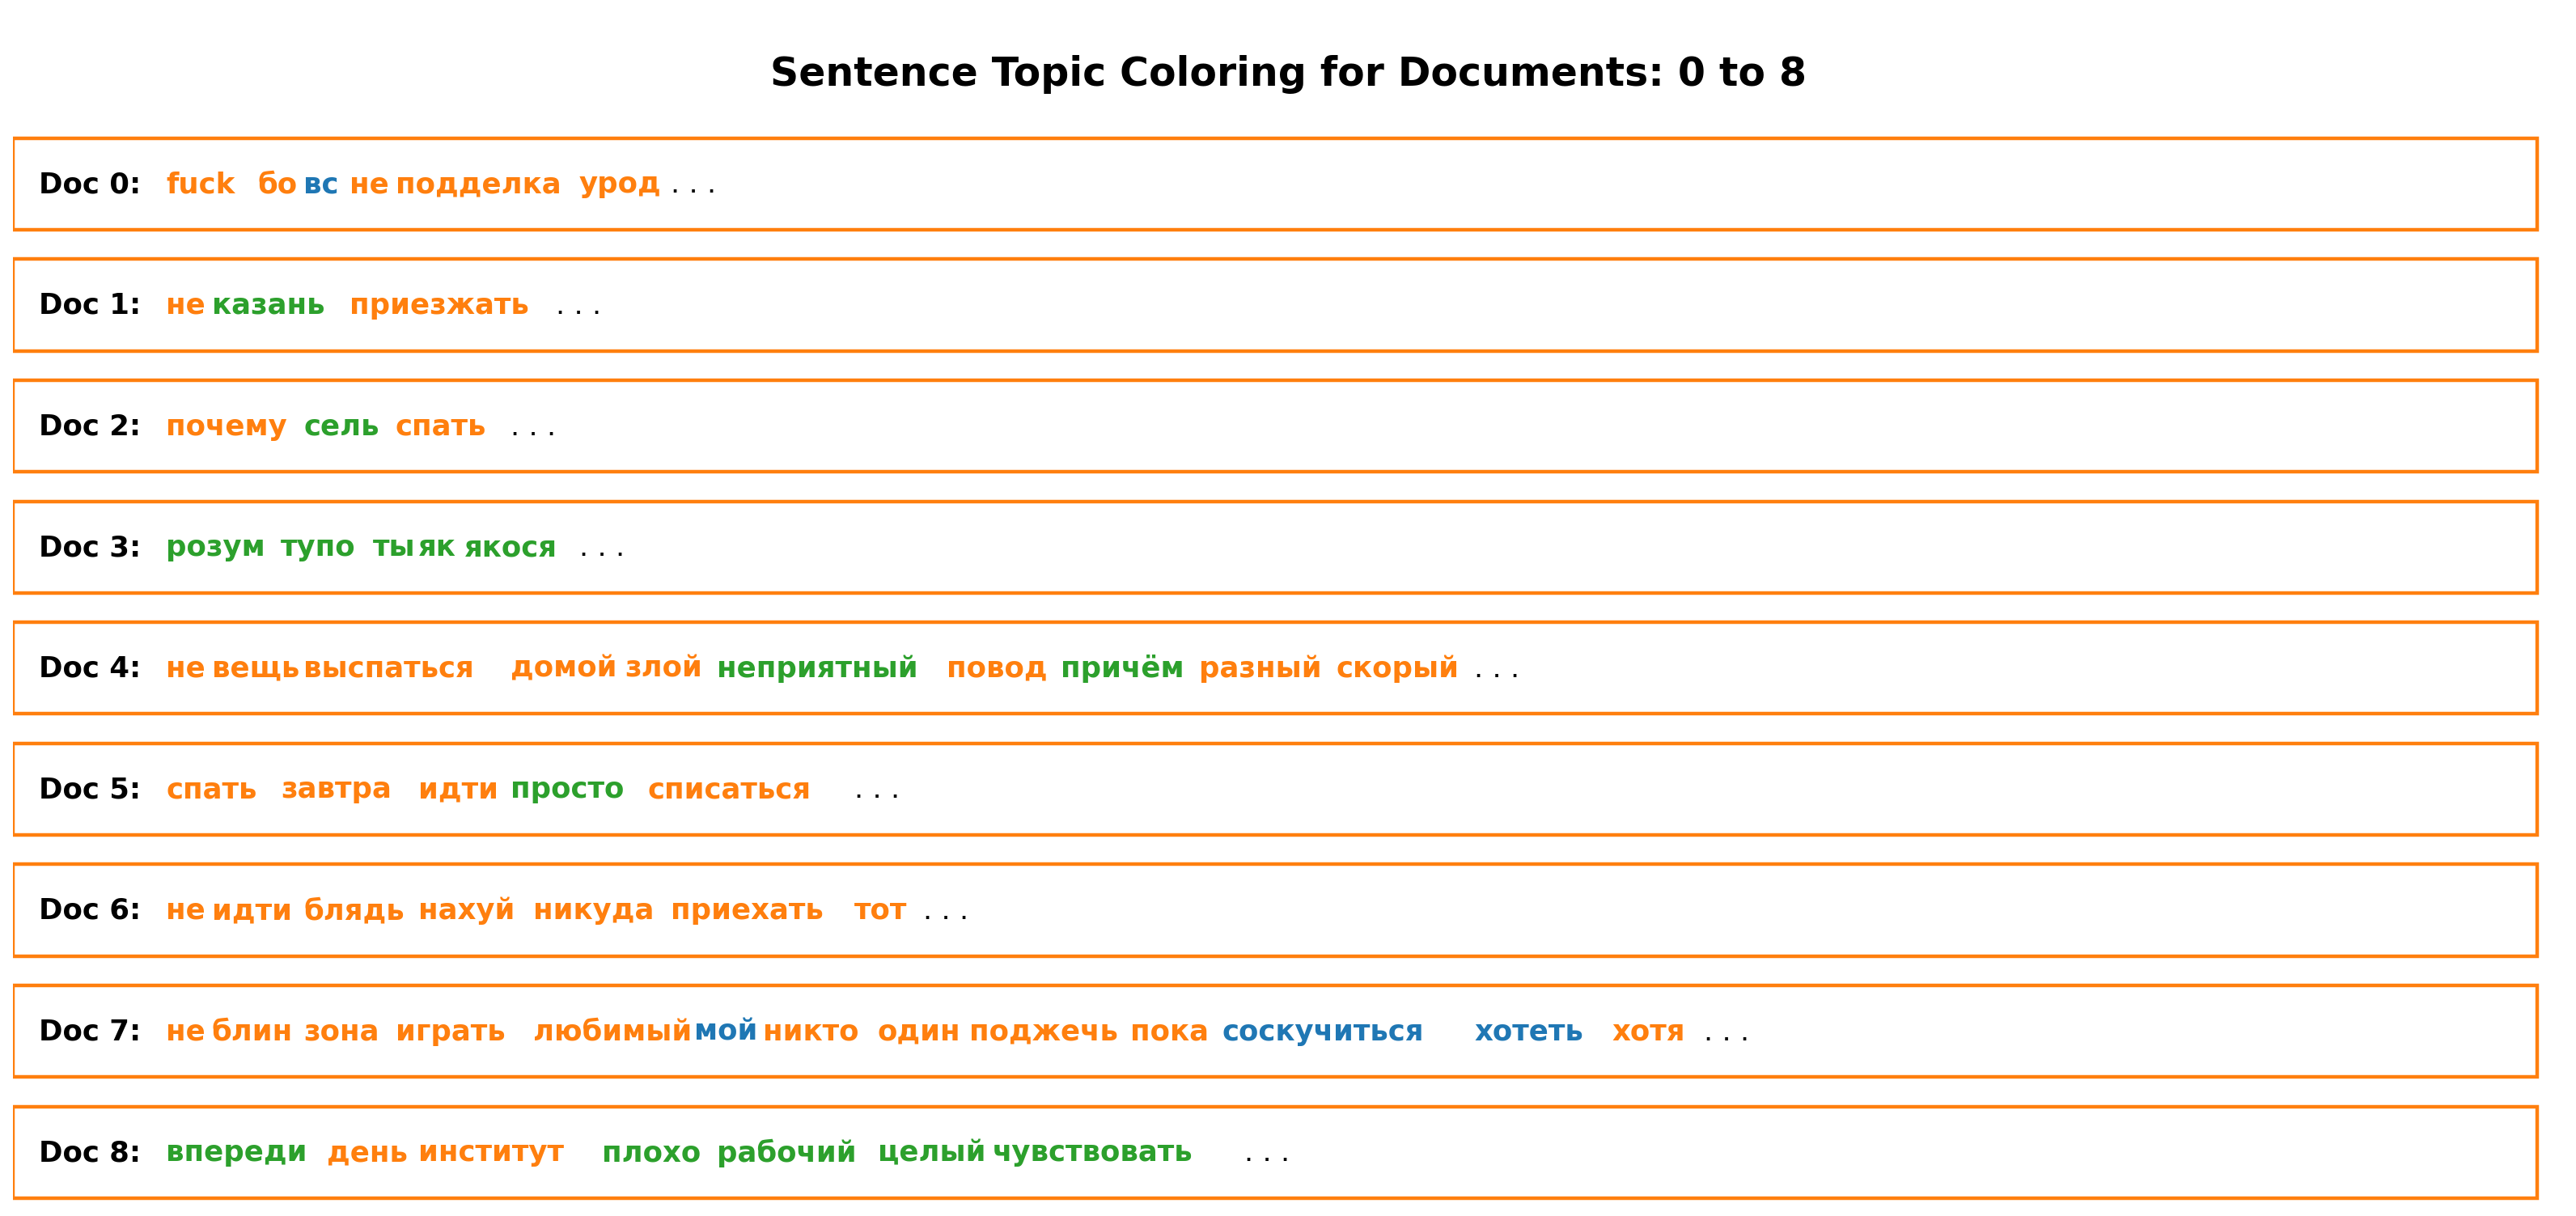

In [106]:
def sentences_chart(lda_model=lda, corpus=corpus, start=0, end=10):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()  

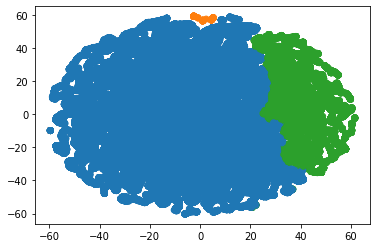

In [46]:
from sklearn.manifold import TSNE

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, perplexity=30, verbose=0, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plt.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
plt.show()

In [ ]:
# better preprocessing is needed

In [65]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           chunksize=50,
                                           passes=2,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=df["text_prep"], dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
# skip: takes too long
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 6
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.4))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.4))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

pbar = tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

# iterate through validation corpuses
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                k=k, a=a, b=b)
                # Save the model results
                model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                
                pbar.update(1)
results = pd.DataFrame(model_results)
pbar.close()

**Add bigrams**

In [107]:
# add bigrams
bigram = gensim.models.Phrases(df["text_prep"], min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [108]:
data_words_bigrams = make_bigrams(df["text_prep"])

In [109]:
bidictionary = corpora.Dictionary(data_words_bigrams)
bidictionary.filter_extremes(no_below=10, no_above=0.8, keep_n=None)

bicorpus = [bidictionary.doc2bow(text) for text in data_words_bigrams]

In [110]:
bilda = gensim.models.ldamodel.LdaModel(bicorpus, 
                                        id2word=bidictionary, 
                                        num_topics=3, 
                                        chunksize=50, 
                                        update_every=1, 
                                        passes=4, 
                                        per_word_topics=True, 
                                        alpha='auto', 
                                        random_state=42)

In [111]:
print('Персплексия: ', np.exp(bilda.log_perplexity(bicorpus)))

coherence_model_lda = gensim.models.CoherenceModel(model=bilda, texts=data_words_bigrams, dictionary=bidictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)  # worse results

Персплексия:  0.00034792452603665054
Средняя когерентность:  0.09976102919058076


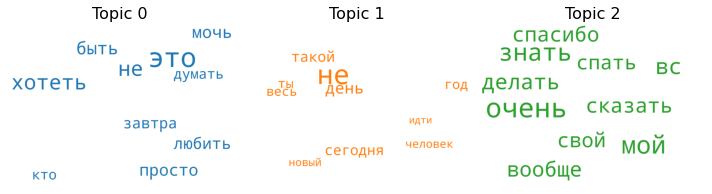

In [112]:
cloud = WordCloud(stopwords=russian+english,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = bilda.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

**Refit with stronger cleaning & bigrams & low word frequency**

In [68]:
cache = {}

def preprocess(text: str, 
               remove_punct: bool = True,
               lemma: bool = True,
               min_length: int = 1) -> list:

    if not isinstance(text, str):
        text = str(text)

    text = re.sub("@[\w]*", ' ', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub("\s\s+", " ", text)

    if remove_punct:
        text = re.sub(r"[^a-zA-Zа-яА-Я0-9]", " ", text)
        text = re.sub(r"[^a-zA-Zа-яА-Я]", " ", text)
        text = re.sub(r"[^\w\s]", " ", text)
    else:
        text = re.sub(f"[^a-zA-Zа-яА-Я{punctuation}]", " ", text)

    text = text.lower().strip().replace(',', '')
    text = text.replace(" не ", " не_")
    text = re.sub(r"(rt|gt|ff|dd)+", " ", text)
    text = [w for w in text.split() if len(w) > min_length]
    text = ' '.join([w for w in text if w not in russian and w not in english])
    
    text = wp_tokenize.tokenize(text)
    if lemma:
        lemm_text = []
        for word in text:
            if word in cache:
                lemm_text.append(cache[word])
            else:
                temp_w = cache[word] = pymorphy2_analyzer.parse(word)[0].normal_form
                lemm_text.append(temp_w)
        lemm_text = [w for w in text if w not in russian + english + ["это", "ты"]]
        return lemm_text
    
    return text

In [69]:
df["text_prep"] = df["text"].apply(partial(preprocess, min_length=2))

In [70]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [71]:
bigram = gensim.models.Phrases(df["text_prep"], min_count=5, threshold=20)
bigram_mod = gensim.models.phrases.Phraser(bigram)

data_words_bigrams = make_bigrams(df["text_prep"])

In [89]:
dictionary = corpora.Dictionary(data_words_bigrams)
dictionary.filter_extremes(no_below=100, no_above=0.8, keep_n=None)
dictionary.filter_n_most_frequent(100)

corpus = [dictionary.doc2bow(text) for text in data_words_bigrams]

In [90]:
len(dictionary)

1675

In [92]:
lda = gensim.models.ldamodel.LdaModel(corpus, 
                                      id2word=dictionary, 
                                      num_topics=2, 
                                      chunksize=50, 
                                      update_every=0, 
                                      passes=10, 
                                      per_word_topics=True, 
                                      alpha='auto',
                                      eta='auto', 
                                      random_state=42)

In [93]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

coherence_lda = gensim.models.CoherenceModel(model=lda, texts=data_words_bigrams, dictionary=dictionary, coherence='c_v').get_coherence()
print('Средняя когерентность: ', coherence_lda)

Персплексия:  0.0007046966211770035
Средняя когерентность:  0.5887285595494681


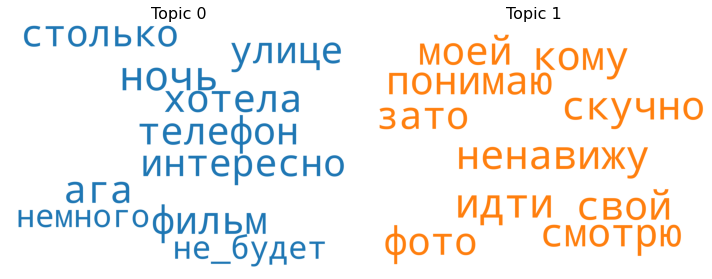

In [95]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=russian+english,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(num_words=10, formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [96]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)